## Setup

In [2]:
from openai import OpenAI
import pandas as pd
from tqdm import tqdm
import csv
import json
from time import sleep
import os
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
keys = json.load(open("keys.json"))
DEEPINFRA_API_KEY = keys["DEEPINFRA_API_KEY"]

In [3]:
openai = OpenAI(
    api_key=DEEPINFRA_API_KEY,
    base_url="https://api.deepinfra.com/v1/openai",
)

In [4]:
def generate_response(
    model,
    prompt,
    system_prompt="You're a helpful assistant",
    suffix_prompt='',
    model_config=None
):
    """
    Returns the response from the model

    Args:
        model (str): Model name
        prompt (str): prompt text
        system_prompt (str): System prompt
        suffix_prompt (str): Suffix prompt to append to the prompt
        model_config (dict): Model parameters
    Returns:
        response_text (str): Response text from the model
        final_answer (str): Final numerical answer
    """
    chat_completion = openai.chat.completions.create(
        model=model,
        messages=[
            { "role": "system", "content": system_prompt },
            { "role": "user", "content": prompt + suffix_prompt },
        ],
        **model_config
    )
    response_text = chat_completion.choices[0].message.content
    final_answer = response_text.split("#### ")[-1].strip()

    try:
        cleaned_answer = final_answer.replace(",", "")  # remove commas
        cleaned_answer = cleaned_answer.replace("$", "")    # remove dollar signs
        final_answer = float(cleaned_answer)
    except Exception:
        pass

    return (response_text, final_answer)

In [5]:
def save_results(filepath, results, model, model_config, system_prompt, suffix_prompt):
    # Add config details to results
    results_with_config = {}
    results_with_config["config"] = {
        "model": model,
        "model_config": model_config,
        "prompt_config": {
            "system_prompt": system_prompt,
            "suffix_prompt": suffix_prompt
        }
    }
    results_with_config["results"] = results

    with open(filepath, "w") as fd:
        json.dump(results_with_config, fd, indent=4)

    print(f"Results saved to {filepath}")

## Sample Inference

In [6]:
model = "meta-llama/Meta-Llama-3.1-8B-Instruct"
system_prompt = "You are a helpful assistant. Do not use or generate code in your responses."

In [7]:
question = "What is 546588 + 493181?"
suffix_prompt = "\n Also append the final numerical answer on a new line append with '#### '"

In [10]:
chat_completion = openai.chat.completions.create(
    model=model,
    messages=[
        { "role": "system", "content": system_prompt },
        { "role": "user", "content": question + suffix_prompt },
    ]
)

In [11]:
print(chat_completion.choices[0].message.content)

The result of the calculation is 1039769.

#### 1039769


In [13]:
model_config = {
    "max_tokens": 512,   # max number of completion tokens, including visible output tokens and reasoning tokens
    "max_completion_tokens": 512,   # max number of completion tokens, including visible output tokens and reasoning tokens
    "stream": False,            # whether to stream the output via SSE or return the full response
    "temperature": 0.7,         # sampling temperature to use, between 0 and 2
    "top_p": 0.9,               # considers the results of the tokens with top_p probability mass
    "n": 1,                     # number of sequences to generate
    "presence_penalty": 0.0,    # penalize new tokens based on whether they appear in the text so far, increasing the model's likelihood to talk about new topics
    "frequency_penalty": 0.0,   # penalize new tokens based on their existing frequency in the text so far, decreasing the model's likelihood to repeat the same line verbatim
    "tools": [],                # A list of tools the model may call. Currently, only functions are supported as a tool.
    "tool_choice": None,        # None: no function call, auto: model can pick between generating a message or calling a function
    "seed": 0
}

In [14]:
def generate_response(
    model,
    prompt,
    system_prompt="You're a helpful assistant",
    suffix_prompt='',
    model_config=None
):
    """
    Returns the response from the model

    Args:
        model (str): Model name
        prompt (str): prompt text
        system_prompt (str): System prompt
        suffix_prompt (str): Suffix prompt to append to the prompt
        model_config (dict): Model parameters
    Returns:
        response_text (str): Response text from the model
        final_answer (str): Final numerical answer
    """
    chat_completion = openai.chat.completions.create(
        model=model,
        messages=[
            { "role": "system", "content": system_prompt },
            { "role": "user", "content": prompt + suffix_prompt },
        ],
        **model_config
    )
    response_text = chat_completion.choices[0].message.content
    final_answer = response_text.split("#### ")[-1].strip()

    try:
        cleaned_answer = final_answer.replace(",", "")  # remove commas
        cleaned_answer = cleaned_answer.replace("$", "")    # remove dollar signs
        final_answer = float(cleaned_answer)
    except Exception:
        pass

    return (response_text, final_answer)

In [15]:
response_text, final_answer = generate_response(model, question, system_prompt=system_prompt, suffix_prompt=suffix_prompt, model_config=model_config)
print(f"response_text: {response_text}")
print(f"final_answer: {final_answer}")

response_text: To calculate the sum, I'll add 546588 and 493181.

546588 + 493181 = 1,039,769

#### 1039769
final_answer: 1039769.0


## Arithmetic Length Generalization Dataset (ALGD) Inference

In [16]:
model = "meta-llama/Meta-Llama-3.1-8B-Instruct"
system_prompt = "You are a helpful assistant. Do not use or generate code in your responses."
suffix_prompt = "\n Also append the final numerical answer on a new line append with '#### '"

In [ ]:

"You are a helpful assistant. Do not use or generate code in your responses. Also append the final numerical answer on a new line append with '#### '"

In [17]:
model_config = {
    "max_tokens": 512,   # max number of completion tokens, including visible output tokens and reasoning tokens
    "max_completion_tokens": 512,   # max number of completion tokens, including visible output tokens and reasoning tokens
    "stream": False,            # whether to stream the output via SSE or return the full response
    "temperature": 0.7,         # sampling temperature to use, between 0 and 2
    "top_p": 0.9,               # considers the results of the tokens with top_p probability mass
    "n": 1,                     # number of sequences to generate
    "presence_penalty": 0.0,    # penalize new tokens based on whether they appear in the text so far, increasing the model's likelihood to talk about new topics
    "frequency_penalty": 0.0,   # penalize new tokens based on their existing frequency in the text so far, decreasing the model's likelihood to repeat the same line verbatim
    "tools": [],                # A list of tools the model may call. Currently, only functions are supported as a tool.
    "tool_choice": None,        # None: no function call, auto: model can pick between generating a message or calling a function
    "seed": 0
}

In [ ]:
def evaluate_file(file_path):
    # Load CSV file into a DataFrame
    data = pd.read_csv(file_path)

    # Assuming the file has "Question" and "Answer" columns
    correct_count = 0
    results = []

    for _, row in tqdm(data.iterrows(), total=len(data)):
        question = row["Question"]
        correct_answer = row["Answer"]

        # convert to float
        correct_answer = float(correct_answer)

        # Get GPT-4's answer
        response_text, predicted_final_answer = generate_response(
            model,
            question,
            system_prompt=system_prompt,
            suffix_prompt=suffix_prompt,
            model_config=model_config
        )

        # Evaluate correctness
        is_correct = predicted_final_answer == correct_answer

        if is_correct:
            correct_count += 1

        # Append result
        results.append({
            "Question": question,
            "Response Text": response_text,
            "Predicted Answer": predicted_final_answer,
            "Correct Answer": correct_answer,
            "Is Correct": is_correct
        })

        sleep(1)    # sleep to avoid rate limiting

    # Calculate accuracy
    total_questions = len(data)
    accuracy = (correct_count / total_questions) * 100
    print(f"Accuracy for {file_path.split('/')[-1]}: {accuracy:.2f}%")

    # Save results for this file
    output_file = file_path.replace(".csv", "_evaluation_results.csv")
    with open(output_file, "w", newline="") as csvfile:
        fieldnames = ["Question", "Response Text", "Predicted Answer", "Correct Answer", "Is Correct"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for result in results:
            writer.writerow(result)

    print(f"Results for {file_path} saved to {output_file}")

### Addition

In [21]:
file_paths = [
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/1-d-add.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/2-d-add.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/3-d-add.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/4-d-add.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/5-d-add.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/6-d-add.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/7-d-add.csv'
]

In [22]:
for file_path in file_paths:
    evaluate_file(file_path)

100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


Accuracy for 1-d-add.csv: 100.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/1-d-add.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/1-d-add_evaluation_results.csv


100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Accuracy for 2-d-add.csv: 100.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/2-d-add.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/2-d-add_evaluation_results.csv


100%|██████████| 100/100 [02:33<00:00,  1.53s/it]


Accuracy for 3-d-add.csv: 97.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/3-d-add.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/3-d-add_evaluation_results.csv


100%|██████████| 100/100 [02:34<00:00,  1.55s/it]


Accuracy for 4-d-add.csv: 97.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/4-d-add.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/4-d-add_evaluation_results.csv


100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


Accuracy for 5-d-add.csv: 91.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/5-d-add.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/5-d-add_evaluation_results.csv


100%|██████████| 100/100 [02:39<00:00,  1.60s/it]


Accuracy for 6-d-add.csv: 96.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/6-d-add.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/6-d-add_evaluation_results.csv


100%|██████████| 100/100 [02:36<00:00,  1.57s/it]

Accuracy for 7-d-add.csv: 82.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/7-d-add.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/add/7-d-add_evaluation_results.csv


### Multiplication

In [23]:
file_paths = [
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/1-d-MUL.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/2-d-MUL.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/3-d-MUL.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/4-d-MUL.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/5-d-MUL.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/6-d-MUL.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/7-d-MUL.csv'
]

In [24]:
for file_path in file_paths:
    evaluate_file(file_path)

100%|██████████| 100/100 [02:21<00:00,  1.42s/it]


Accuracy for 1-d-MUL.csv: 100.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/1-d-MUL.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/1-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


Accuracy for 2-d-MUL.csv: 83.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/2-d-MUL.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/2-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


Accuracy for 3-d-MUL.csv: 17.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/3-d-MUL.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/3-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [03:03<00:00,  1.83s/it]


Accuracy for 4-d-MUL.csv: 2.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/4-d-MUL.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/4-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


Accuracy for 5-d-MUL.csv: 0.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/5-d-MUL.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/5-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


Accuracy for 6-d-MUL.csv: 0.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/6-d-MUL.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/6-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [03:10<00:00,  1.90s/it]

Accuracy for 7-d-MUL.csv: 0.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/7-d-MUL.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/dataset/multiply/7-d-MUL_evaluation_results.csv


## Plotting Results

### Fixing the results

In [15]:
def fix_results(file_path):
    # Load CSV file into a DataFrame
    data = pd.read_csv(file_path)

    # Assuming the file has "Question" and "Answer" columns
    correct_count = 0

    for _, row in tqdm(data.iterrows(), total=len(data)):
        predicted_answer = row["Predicted Answer"]
        correct_answer = row["Correct Answer"]

        # convert to integer
        predicted_answer = int(float(predicted_answer))
        correct_answer = int(float(correct_answer))

        # Evaluate correctness
        is_correct = predicted_answer == correct_answer

        if is_correct:
            correct_count += 1

        data["Is Correct"] = is_correct

    # Calculate accuracy
    total_questions = len(data)
    accuracy = (correct_count / total_questions) * 100
    print(f"Accuracy for {file_path.name}: {accuracy:.2f}%")

    # Dump results back to file
    with open(file_path, "w", newline="") as csvfile:
        data.to_csv(csvfile, index=False)

    print(f"Results for {file_path} saved to {file_path}")

In [26]:
results_dir = Path('/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/')
addition_results_dir = results_dir / 'add'
multiplication_results_dir = results_dir / 'multiply'

# get all csv files in the addition_results directory
addition_files = list(addition_results_dir.glob('*.csv'))
multiplication_files = list(multiplication_results_dir.glob('*.csv'))

In [23]:
for file_path in addition_files:
    try:
        fix_results(file_path)
    except:
        print(f"Error processing {file_path}")

100%|██████████| 100/100 [00:00<00:00, 163.92it/s]


Accuracy for 3-d-add_evaluation_results.csv: 95.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/add/3-d-add_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/add/3-d-add_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 11922.07it/s]


Accuracy for 5-d-add_evaluation_results.csv: 60.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/add/5-d-add_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/add/5-d-add_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 1009.43it/s]


Accuracy for 6-d-add_evaluation_results.csv: 43.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/add/6-d-add_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/add/6-d-add_evaluation_results.csv


100%|██████████| 100/100 [00:01<00:00, 78.83it/s]


Accuracy for 7-d-add_evaluation_results.csv: 34.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/add/7-d-add_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/add/7-d-add_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 207.04it/s]


Accuracy for 4-d-add_evaluation_results.csv: 76.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/add/4-d-add_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/add/4-d-add_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 382.59it/s]


Accuracy for 2-d-add_evaluation_results.csv: 97.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/add/2-d-add_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/add/2-d-add_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 127.60it/s]

Accuracy for 1-d-add_evaluation_results.csv: 100.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/add/1-d-add_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/add/1-d-add_evaluation_results.csv


In [30]:
for file_path in multiplication_files:
    try:
        fix_results(file_path)
    except Exception as e:
        print(f"Error processing {file_path}")
        print(e)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 15903.78it/s]


Accuracy for 5-d-MUL_evaluation_results.csv: 0.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/multiply/5-d-MUL_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/multiply/5-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 29155.46it/s]


Accuracy for 6-d-MUL_evaluation_results.csv: 0.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/multiply/6-d-MUL_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/multiply/6-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 18780.75it/s]


Accuracy for 3-d-MUL_evaluation_results.csv: 1.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/multiply/3-d-MUL_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/multiply/3-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 19421.67it/s]


Accuracy for 2-d-MUL_evaluation_results.csv: 27.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/multiply/2-d-MUL_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/multiply/2-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 18555.58it/s]


Accuracy for 1-d-MUL_evaluation_results.csv: 100.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/multiply/1-d-MUL_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/multiply/1-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 14960.42it/s]


Accuracy for 7-d-MUL_evaluation_results.csv: 0.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/multiply/7-d-MUL_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/multiply/7-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 28119.50it/s]

Accuracy for 4-d-MUL_evaluation_results.csv: 0.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/multiply/4-d-MUL_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gemma-2b-it/multiply/4-d-MUL_evaluation_results.csv


In [34]:
results_dir = Path('/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/')
addition_results_dir = results_dir / 'add'
multiplication_results_dir = results_dir / 'multiply'

# get all csv files in the addition_results directory
addition_files = sorted(list(addition_results_dir.glob('*.csv')))
multiplication_files = sorted(list(multiplication_results_dir.glob('*.csv')))

In [37]:
answer = "The rows of 8 stars have a total of: 3 rows * 8 stars/row = <<3*8=24>>24 stars.\nThe rows of 6 stars have a total of: 2 rows * 6 stars/row = <<2*6=12>>12 stars.\nIncluding the rows of 8 and 6 stars, we have 24 stars + 12 stars = <<24+12=36>>36 stars.\nNow we need to know how many stars are missing, 76 stars - 36 stars = <<76-36=40>>40 stars.\nNow we need to distribute the missing stars in rows of 5 stars, 40 stars/5 rows = <<40/5=8>>8 rows of 5 stars.\n#### 8"
print(answer)

The rows of 8 stars have a total of: 3 rows * 8 stars/row = <<3*8=24>>24 stars.
The rows of 6 stars have a total of: 2 rows * 6 stars/row = <<2*6=12>>12 stars.
Including the rows of 8 and 6 stars, we have 24 stars + 12 stars = <<24+12=36>>36 stars.
Now we need to know how many stars are missing, 76 stars - 36 stars = <<76-36=40>>40 stars.
Now we need to distribute the missing stars in rows of 5 stars, 40 stars/5 rows = <<40/5=8>>8 rows of 5 stars.
#### 8


In [36]:
for file_path in addition_files + multiplication_files:
    try:
        fix_results(file_path)
    except Exception as e:
        print(f"Error processing {file_path}")
        print(e)

100%|██████████| 100/100 [00:00<00:00, 19451.39it/s]


Accuracy for 1-d-add_evaluation_results.csv: 100.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/1-d-add_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/1-d-add_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 27767.65it/s]


Accuracy for 2-d-add_evaluation_results.csv: 100.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/2-d-add_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/2-d-add_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 27811.84it/s]


Accuracy for 3-d-add_evaluation_results.csv: 97.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/3-d-add_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/3-d-add_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 19731.40it/s]


Accuracy for 4-d-add_evaluation_results.csv: 97.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/4-d-add_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/4-d-add_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 14965.76it/s]


Accuracy for 5-d-add_evaluation_results.csv: 91.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/5-d-add_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/5-d-add_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 20533.14it/s]


Accuracy for 6-d-add_evaluation_results.csv: 96.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/6-d-add_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/6-d-add_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 17254.12it/s]


Accuracy for 7-d-add_evaluation_results.csv: 82.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/7-d-add_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/7-d-add_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 15646.89it/s]


Accuracy for 1-d-MUL_evaluation_results.csv: 100.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/multiply/1-d-MUL_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/multiply/1-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 21049.40it/s]


Accuracy for 2-d-MUL_evaluation_results.csv: 83.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/multiply/2-d-MUL_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/multiply/2-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 22993.83it/s]


Accuracy for 3-d-MUL_evaluation_results.csv: 17.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/multiply/3-d-MUL_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/multiply/3-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 16540.36it/s]


Accuracy for 4-d-MUL_evaluation_results.csv: 2.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/multiply/4-d-MUL_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/multiply/4-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 17262.64it/s]


Accuracy for 5-d-MUL_evaluation_results.csv: 0.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/multiply/5-d-MUL_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/multiply/5-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 22651.10it/s]


Accuracy for 6-d-MUL_evaluation_results.csv: 0.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/multiply/6-d-MUL_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/multiply/6-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [00:00<00:00, 14700.87it/s]

Accuracy for 7-d-MUL_evaluation_results.csv: 0.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/multiply/7-d-MUL_evaluation_results.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/multiply/7-d-MUL_evaluation_results.csv


### Accuracy

In [ ]:
results_dir = Path('/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/')
addition_results_dir = results_dir / 'add'
multiplication_results_dir = results_dir / 'multiply'

# get all csv files in the addition_results directory
addition_files = list(addition_results_dir.glob('*.csv'))
multiplication_files = list(multiplication_results_dir.glob('*.csv'))

# read the csv files into a list of dataframes
addition_dfs = [pd.read_csv(file) for file in addition_files]
multiplication_dfs = [pd.read_csv(file) for file in multiplication_files]

### Digit Match plots

In [48]:
# Function to compare digits up to the length of the shorter number
def compare_digits(predicted, correct):
    predicted_str = str(int(float(predicted)))
    correct_str = str(int(float(correct)))
    min_len = min(len(predicted_str), len(correct_str))

    # Compare digits up to the length of the shorter number
    digit_matches = [predicted_str[i] == correct_str[i] for i in range(min_len)]

    return digit_matches

In [52]:
from pathlib import Path

results_dir = Path('/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/')
addition_results_dir = results_dir / 'add'
multiplication_results_dir = results_dir / 'multiply'

# get all csv files in the addition_results directory
addition_files = list(addition_results_dir.glob('*.csv'))
multiplication_files = list(multiplication_results_dir.glob('*.csv'))

# read the csv files into a list of dataframes
addition_dfs = [pd.read_csv(file) for file in addition_files]
multiplication_dfs = [pd.read_csv(file) for file in multiplication_files]

digit_matches_dir = addition_results_dir / 'digit_matches'
digit_matches_dir.mkdir(parents=True, exist_ok=True)

for filename, df in zip(addition_files, addition_dfs):
    for index, row in df.iterrows():
        digit_matches = compare_digits(row['Predicted Answer'], row['Correct Answer'])
        for i, match in enumerate(digit_matches):
            column_name = f'Digit_{i+1}_Match'
            df.at[index, column_name] = match

    digit_matches_file = digit_matches_dir / Path(filename.stem + '_digit_matches.csv')

    # Save the updated DataFrame to a new CSV file
    df.to_csv(digit_matches_file, index=False)
    print(f"Saved digit matches to {digit_matches_file}")

digit_matches_dir = multiplication_results_dir / 'digit_matches'
digit_matches_dir.mkdir(parents=True, exist_ok=True)

for filename, df in zip(multiplication_files, multiplication_dfs):
    for index, row in df.iterrows():
        digit_matches = compare_digits(row['Predicted Answer'], row['Correct Answer'])
        for i, match in enumerate(digit_matches):
            column_name = f'Digit_{i+1}_Match'
            df.at[index, column_name] = match

    digit_matches_file = digit_matches_dir / Path(filename.stem + '_digit_matches.csv')

    # Save the updated DataFrame to a new CSV file
    df.to_csv(digit_matches_file, index=False)
    print(f"Saved digit matches to {digit_matches_file}")

Saved digit matches to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/digit_matches/3-d-add_evaluation_results_digit_matches.csv
Saved digit matches to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/digit_matches/5-d-add_evaluation_results_digit_matches.csv
Saved digit matches to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/digit_matches/6-d-add_evaluation_results_digit_matches.csv
Saved digit matches to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/digit_matches/7-d-add_evaluation_results_digit_matches.csv
Saved digit matches to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/digit_matches/4-d-add_evaluation_results_digit_matches.csv
Saved digit matches to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/add/digit_matches/2-d-add_evaluation_

In [27]:
import matplotlib.pyplot as plt

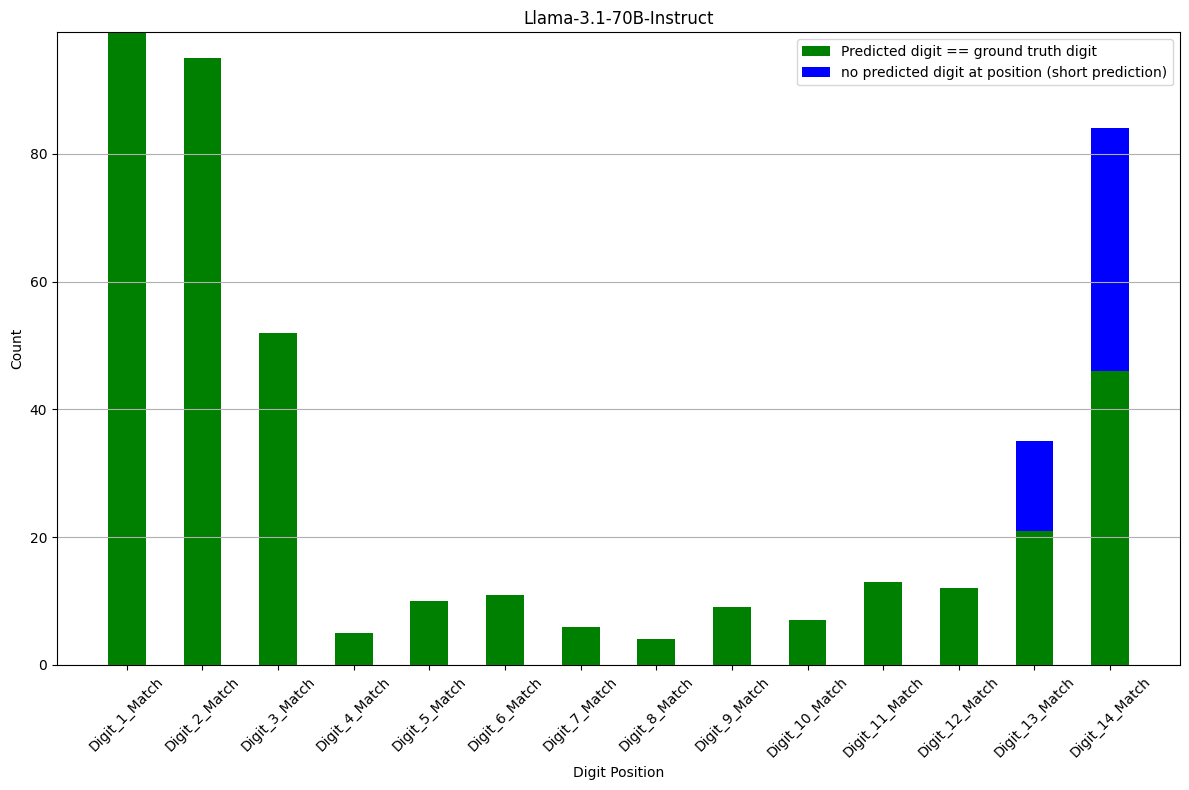

In [34]:
results_csv = '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-8b/multiply/llama-3.1-8b-Instruct-7d-mul_digit_matches.csv'

df = pd.read_csv(results_csv)
df_matches = df.copy()  # create a copy

# Extract digit match columns
digit_match_columns = [col for col in df_matches.columns if col.startswith('Digit_')]

# Initialize dictionaries to store counts
true_counts = {}
false_counts = {}
nan_counts = {}

# Count True, False, and NaN values for each digit match column
for col in digit_match_columns:
    true_counts[col] = df_matches[col].sum()
    false_counts[col] = df_matches[col].count() - df_matches[col].sum()
    nan_counts[col] = df_matches[col].isna().sum()

# Plot the data
x = range(len(digit_match_columns))
width = 0.5  # width of the bars

plt.figure(figsize=(12, 8))
# plt.bar(x, [true_counts[col] for col in digit_match_columns], label='True', color='g', width=width)
# plt.bar(x, [false_counts[col] for col in digit_match_columns], bottom=[true_counts[col] for col in digit_match_columns], label='False', color='r', width=width)
# plt.bar(x, [nan_counts[col] for col in digit_match_columns], bottom=[true_counts[col] + false_counts[col] for col in digit_match_columns], label='NaN', color='b', width=width)

plt.bar(x, [true_counts[col] for col in digit_match_columns], label='Predicted digit == ground truth digit', color='g', width=width)
plt.bar(x, [nan_counts[col] for col in digit_match_columns], bottom=[true_counts[col] for col in digit_match_columns], label='no predicted digit at position (short prediction)', color='b', width=width)

plt.xlabel('Digit Position')
plt.ylabel('Count')
# plt.title('% of matches for each digit position')
plt.title('Llama-3.1-70B-Instruct')
plt.xticks(x, digit_match_columns, rotation=45)
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()